Importing some of the libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

Doing some data clearing and manipulation

In [2]:
brexit_results = pd.read_csv("EU-referendum-result-data.csv")
brexit_results=brexit_results.filter(["Region_Code","Region","Area","Electorate","Pct_Remain","Pct_Leave"])
london=brexit_results[brexit_results["Region"]=="London"] #Choosing london for the preliminary research
london.index = london["Area"]
london=london.drop(["Region_Code","Region","Area"],axis=1) #Droping the not needed areas
#combining thr results of Hackney and City of London to be consistent with nhs database
london.loc["Hackney","Pct_Remain"]=london.loc["City of London","Pct_Remain"]*(london.loc["City of London","Electorate"]/(london.loc["Hackney","Electorate"]+london.loc["City of London","Electorate"]))+london.loc["Hackney","Pct_Remain"]*(london.loc["Hackney","Electorate"]/(london.loc["Hackney","Electorate"]+london.loc["City of London","Electorate"]))
london.loc["Hackney","Pct_Leave"]=london.loc["City of London","Pct_Leave"]*(london.loc["City of London","Electorate"]/(london.loc["Hackney","Electorate"]+london.loc["City of London","Electorate"]))+london.loc["Hackney","Pct_Leave"]*(london.loc["Hackney","Electorate"]/(london.loc["Hackney","Electorate"]+london.loc["City of London","Electorate"]))
london.loc["Hackney","Electorate"]=london.loc["Westminster","Electorate"]+london.loc["City of London","Electorate"]
london.drop("City of London",inplace=True)

In [3]:
nhs_london_payments = pd.read_excel("nhspaymentsgp-14-15-ann1.xlsx")

In [4]:
nhs_london_payments.index = nhs_london_payments["CCG Description"]

In [5]:
#changing names to make them consistent
london.rename(index={"Hackney":"City and Hackney","Kensington and Chelsea":"West London","Kingston upon Thames":"Kingston","Richmond upon Thames":"Richmond"},inplace=True)
nhs_london_payments.rename(index={nhs_london_payments.index[-1]:"Westminster"},inplace=True)


#merge data
df_merged = pd.merge(london,nhs_london_payments.iloc[:,2],left_index=True, right_index=True)
df_merged
df_merged =pd.merge(df_merged,nhs_london_payments.iloc[:,-3],left_index=True, right_index=True)
df_merged
df_merged.rename(columns={df_merged.columns[-1]:"NHS Payments",df_merged.columns[-2]:"Registered Patients"},inplace=True)

In [6]:
df_merged = pd.merge(df_merged,nhs_london_payments.iloc[:,-1],left_index=True, right_index=True)
df_merged = pd.merge(df_merged,nhs_london_payments.iloc[:,-2],left_index=True, right_index=True)

In [7]:
df_merged
df_merged["Spending Per Patient"]=df_merged["NHS Payments"]/df_merged["Electorate"]

Scatterplots creation using seaborn

[Text(0.5, 1.0, 'Spending per Patient in London Boroughs')]

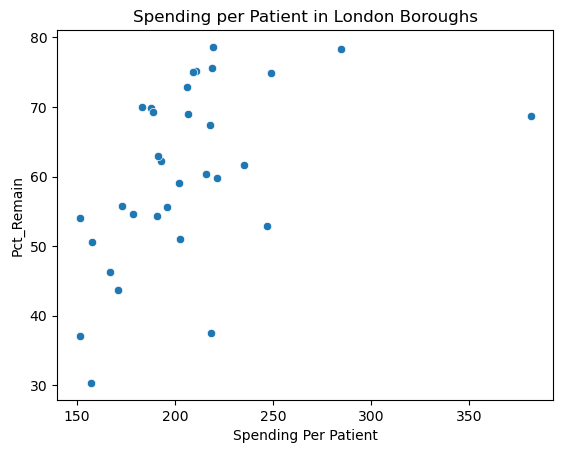

In [8]:
sns.scatterplot(data=df_merged,x="Spending Per Patient",y="Pct_Remain").set(title="Spending per Patient in London Boroughs")
#plt.savefig('Spending per Patient.png')

[Text(0.5, 1.0, 'Surgery Satisfaction in London Boroughs')]

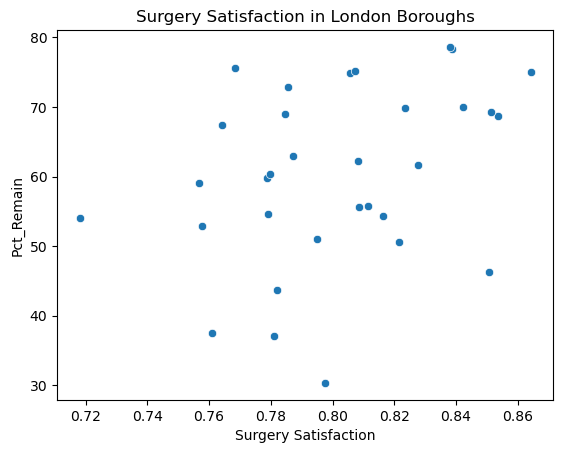

In [9]:
sns.scatterplot(data=df_merged,x="Surgery Satisfaction",y="Pct_Remain").set(title='Surgery Satisfaction in London Boroughs')
#plt.savefig('Surgery Satisfaction.png')

[Text(0.5, 1.0, 'Long term ill. Satisfaction in London Boroughs')]

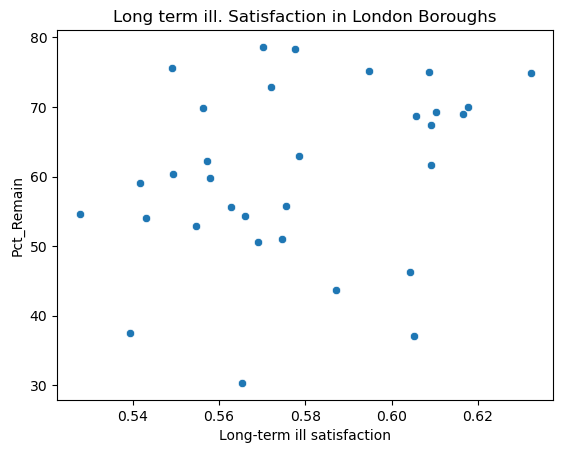

In [10]:
sns.scatterplot(data=df_merged,x="Long-term ill satisfaction",y="Pct_Remain").set(title="Long term ill. Satisfaction in London Boroughs")
#plt.savefig('Long term Ill Satisfaction.png')

In [11]:
df_merged_1=df_merged

**Clustering with Kmeans**

In [18]:
X = df_merged_1.loc[:,["Pct_Remain","Spending Per Patient"]]
k_means=KMeans(n_clusters = 3, init = 'random') 

k_means.fit(X) 
labels = k_means.labels_

df_merged_1["Kmeans"]=labels

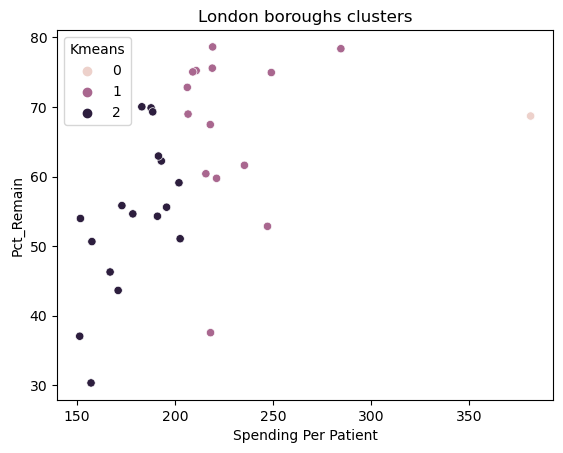

In [19]:
sns.scatterplot(data = df_merged_1, x="Spending Per Patient",y="Pct_Remain", hue = "Kmeans").set(title='London boroughs clusters')

plt.savefig('London Boroughs Clusters.png')

*Map Reading*

In [20]:
import geopandas as gpd 

from osgeo import gdal
gdal.SetConfigOption('SHAPE_RESTORE_SHX','YES')
fp = "statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
map_df=gpd.read_file(fp)

Data Clearing

In [21]:
list(set(df_merged.index)-set(map_df["NAME"])) #checking if there is a difference between the names

['Richmond', 'Kingston', 'City and Hackney', 'West London']

In [22]:
list(set(map_df["NAME"])-set(df_merged.index)) #checking if there is a difference between the names

['Richmond upon Thames',
 'Kingston upon Thames',
 'Kensington and Chelsea',
 'City of London',
 'Hackney']

In [23]:
df_merged.rename(index={"Richmond":"Richmond upon Thames","Kingston":"Kingston upon Thames","West London":"Kensington and Chelsea"},inplace=True)
#renaming to have compatible indices

In [24]:
list(set(map_df["NAME"])-set(df_merged.index))

['City of London', 'Hackney']

In [25]:
df_merged.loc["City of London",:]=df_merged.loc["City and Hackney",:]
df_merged.rename(index={"City and Hackney":"Hackney"},inplace=True)

In [26]:
df_merged.sort_index() #sorting based on the index
df_merged["Kmeans"]=df_merged["Kmeans"].apply(int) #making sure that clusters are integers

***Merging gdp with pd dataframe***

In [27]:
merged=map_df.set_index('NAME').join(df_merged.set_index(df_merged.index)) #creating a new gdp dataframe 

**Map Creation**

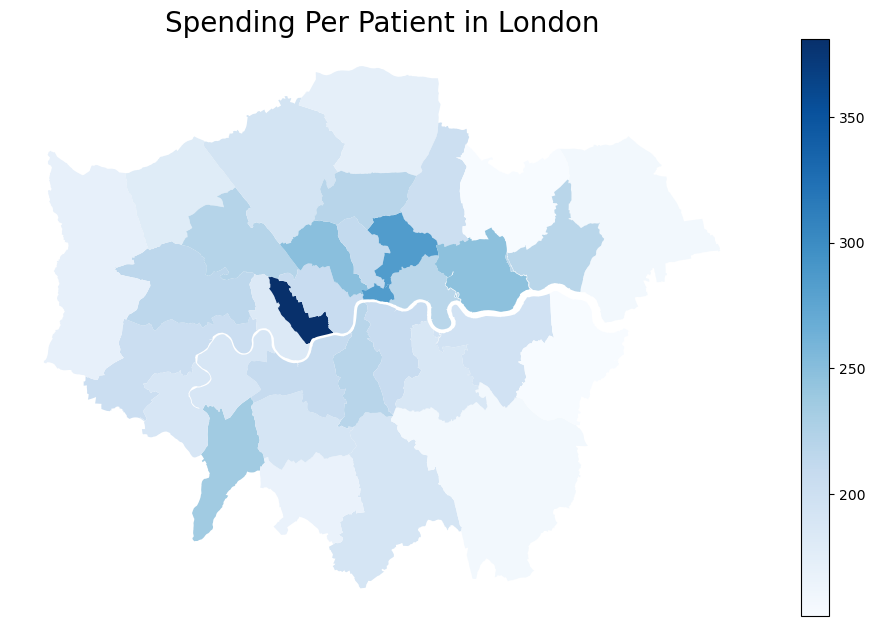

In [28]:
hap='Spending Per Patient'
vmin,vmax=merged[hap].min(),merged[hap].max()
fig,ax=plt.subplots(1,figsize=(12,7.5))
merged.plot(column=hap,cmap='Blues',ax=ax)
ax.axis('off')
plt.title('Spending Per Patient in London',{'fontsize': '20',
 'fontweight' :'100'})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
#plt.savefig('Spending map London.png')

#map creation

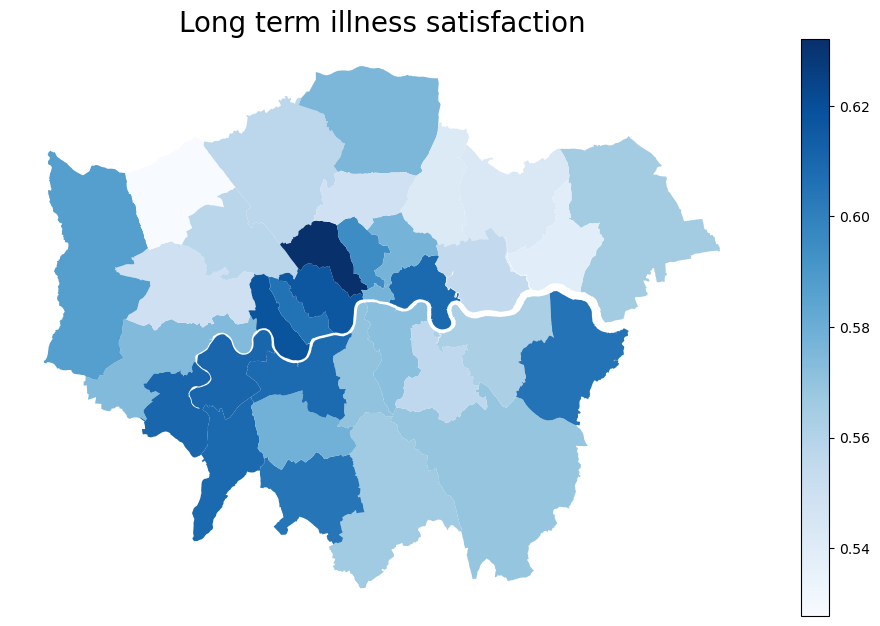

In [29]:
hap='Long-term ill satisfaction'
vmin,vmax=merged[hap].min(),merged[hap].max()
fig,ax=plt.subplots(1,figsize=(12,7.5))
merged.plot(column=hap,cmap='Blues',ax=ax)
ax.axis('off')
plt.title('Long term illness satisfaction',{'fontsize': '20',
 'fontweight' :'100'})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

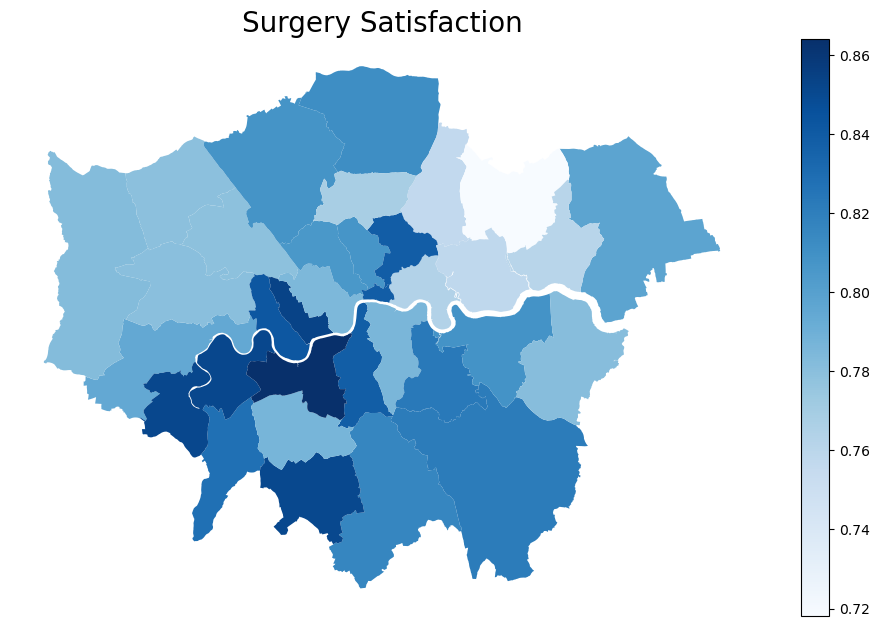

In [30]:
hap='Surgery Satisfaction'
vmin,vmax=merged[hap].min(),merged[hap].max()
fig,ax=plt.subplots(1,figsize=(12,7.5))
merged.plot(column=hap,cmap='Blues',ax=ax)
ax.axis('off')
plt.title('Surgery Satisfaction',{'fontsize': '20',
 'fontweight' :'100'})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

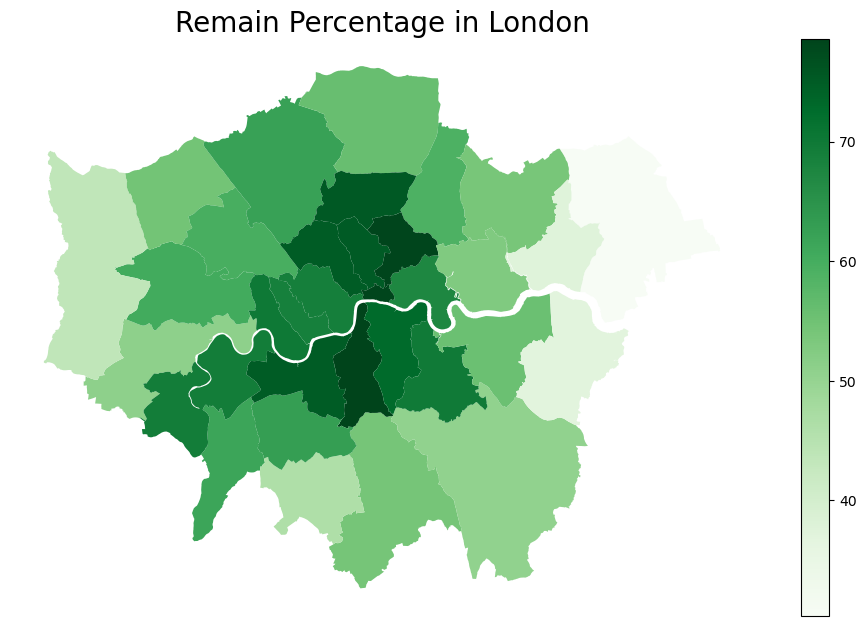

In [31]:
hap='Pct_Remain'
vmin,vmax=merged[hap].min(),merged[hap].max()
fig,ax=plt.subplots(1,figsize=(12,7.5))
merged.plot(column=hap,cmap='Greens',ax=ax)
ax.axis('off')
plt.title('Remain Percentage in London',{'fontsize': '20',
 'fontweight' :'100'})
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
plt.savefig('Remain map London.png')

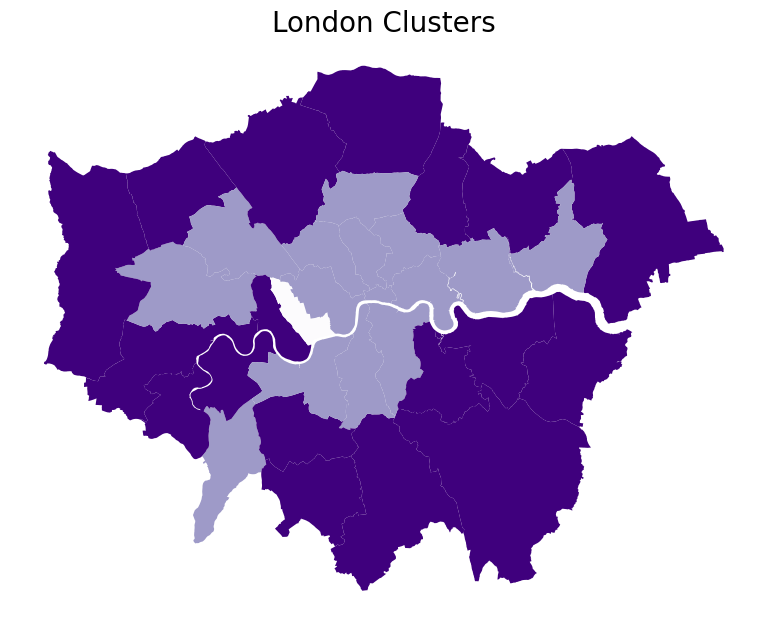

In [32]:
hap='Kmeans'
fig,ax=plt.subplots(1,figsize=(12,7.5))
merged.plot(column=hap,cmap='Purples',ax=ax)
ax.axis('off')
plt.title('London Clusters',{'fontsize': '20',
 'fontweight' :'100'})
sm._A = []
#plt.savefig('Clusters map.png')

Reading new data

In [33]:
nhs_spending_metro = pd.read_excel("nhspaymentsgp-14-15-ann1.xlsx",sheet_name=1,index_col=0) #reading the new excel file
all_uk = brexit_results[brexit_results.Region!="London"] #exluding London
all_uk = all_uk.loc[:,["Area","Electorate","Pct_Leave","Pct_Remain"]]
all_uk

,Area,Electorate,Pct_Leave,Pct_Remain
0,Peterborough,120892,60.89,39.11
1,Luton,127612,56.55,43.45
2,Southend-on-Sea,128856,58.08,41.92
3,Thurrock,109897,72.28,27.72
4,Bedford,119530,51.78,48.22
...,...,...,...,...
377,Bradford,342817,54.23,45.77
378,Calderdale,149195,55.68,44.32
379,Kirklees,307081,54.67,45.33
380,Leeds,543033,49.69,50.31


In [34]:
nhs_spending_metro

,Metropolitan County,Total NHS Payments,Surgery Satisfaction,Long-term ill satisfaction
Area,,,,
Bolton,Greater Manchester,3.482933e+07,0.864921,0.666929
Bury,Greater Manchester,2.125108e+07,0.864399,0.655950
Manchester,Greater Manchester,6.316014e+07,0.821198,0.621552
Oldham,Greater Manchester,2.806523e+07,0.830067,0.648928
Rochdale,Greater Manchester,2.467366e+07,0.834897,0.649811
Salford,Greater Manchester,2.880450e+07,0.862242,0.678768
Stockport,Greater Manchester,3.059116e+07,0.875478,0.647970
Tameside,Greater Manchester,2.752122e+07,0.811689,0.623909
Trafford,Greater Manchester,2.704179e+07,0.867968,0.651478


**Data Clearing**

In [35]:
list(set(nhs_spending_metro.index)-set(all_uk.Area)) #check to see if there are differences in the names, 
#we were quite lucky not to find something

[]

In [36]:
all_uk.index = all_uk.Area

In [37]:
df_merged_metro = pd.merge(nhs_spending_metro,all_uk,left_index=True, right_index=True)
df_merged_metro["Spending Per Patient"]=df_merged_metro["Total NHS Payments"]/df_merged_metro["Electorate"]
#creating the spending per patient dividing total spending per gp by the number of eligable voters

In [38]:
df_merged["Metropolitan County"]="Greater London"

In [39]:
df_merged = df_merged.loc[:,["Metropolitan County","Electorate","Pct_Remain","Pct_Leave","Spending Per Patient","Surgery Satisfaction","Long-term ill satisfaction"]]

In [40]:
df_merged_metro = df_merged_metro.loc[:,["Metropolitan County","Electorate","Pct_Remain","Pct_Leave","Spending Per Patient","Surgery Satisfaction","Long-term ill satisfaction"]]


In [41]:
df_all_uk = pd.concat([df_merged,df_merged_metro])
df_all_uk

#choosing specific fields in two dataframes and concat them

,Metropolitan County,Electorate,Pct_Remain,Pct_Leave,Spending Per Patient,Surgery Satisfaction,Long-term ill satisfaction
Barking and Dagenham,Greater London,115812.0,37.56,62.44,218.098466,0.760976,0.539321
Barnet,Greater London,223467.0,62.23,37.77,193.037751,0.808196,0.557214
Bexley,Greater London,170779.0,37.05,62.95,151.447675,0.781041,0.605147
Brent,Greater London,186793.0,59.74,40.26,221.163597,0.778854,0.557819
Bromley,Greater London,231473.0,50.65,49.35,157.660619,0.821555,0.569056
...,...,...,...,...,...,...,...
Bradford,West Yorkshire,342817.0,45.77,54.23,176.562510,0.804472,0.643127
Calderdale,West Yorkshire,149195.0,44.32,55.68,178.858923,0.875827,0.678653
Leeds,West Yorkshire,543033.0,50.31,49.69,243.029431,0.856263,0.647404
Kirklees,West Yorkshire,307081.0,45.33,54.67,172.238217,0.830282,0.667203


**Inferential Statistics**

In [75]:
import statsmodels.api as sm
x = list(df_all_uk["Spending Per Patient"])
y= list(df_all_uk["Pct_Remain"])
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

#OLS regression

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     23.59
Date:                Fri, 30 Dec 2022   Prob (F-statistic):           8.65e-06
Time:                        13:28:59   Log-Likelihood:                -242.92
No. Observations:                  63   AIC:                             489.8
Df Residuals:                      61   BIC:                             494.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.4266      7.079      2.744      0.0

In [52]:
import scipy.stats as stats

#normality of residuals test

k,p=stats.normaltest(model.resid)
p #null hypotheis is not rejected, residuals are normal


0.14843589177375383

In [56]:
import statsmodels.stats.api as sms

#Heteroskedasticity test

test = sms.het_breuschpagan(model.resid, model.model.exog)
test[1]

#null hypothesis There is no heteroskedasticity:It cannot be rejected

0.13083566677279443

In [59]:
import statsmodels.stats.diagnostic as dg

#Serial correlation test

print(dg.acorr_breusch_godfrey(model, nlags=1))

#Null hypothesis: There is no serial correlation within 1 lag: It is rejected. 
#Therefore, GLS is used

(4.755138517608326, 0.02921094165667399, 4.898428870721105, 0.030695479889219415)


In [89]:
ols_resid = model.resid
ols_resid
res_fit = sm.OLS(ols_resid[1:], ols_resid[:-1]).fit() #test to see if residuals can be estimated with the residuals
res_fit.pvalues[0] #pval < .05 null hypothesis is rejected. It is indeed statistically significant

from scipy.linalg import toeplitz
order = toeplitz(range(len(ols_resid)))
order
rho = res_fit.params[0]
rho
sigma = rho**order #we create the cov matrix
gls_model = sm.GLS(y,x,sigma=sigma)
gls_results = gls_model.fit()
print(gls_results.summary()) #the results

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.217
Model:                            GLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     16.94
Date:                Fri, 30 Dec 2022   Prob (F-statistic):           0.000118
Time:                        13:38:04   Log-Likelihood:                -240.06
No. Observations:                  63   AIC:                             484.1
Df Residuals:                      61   BIC:                             488.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.5509      6.907      3.699      0.0

*Anovas*

In [ ]:
df_all_uk["Geography"]="North" #classification 1

In [40]:
df_all_uk["Geography"][df_all_uk["Metropolitan County"]=="Greater London"]="South" #classification 2

/var/folders/mx/p2w4hq8s647_rdmg660fckgh0000gn/T/ipykernel_7161/2776133965.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_uk["Geography"][df_all_uk["Metropolitan County"]=="Greater London"]="South"


In [41]:
#Anova test 1
stats.f_oneway(df_all_uk["Pct_Remain"][df_all_uk["Geography"]=="North"],
              df_all_uk["Pct_Remain"][df_all_uk["Geography"]=="South"])

F_onewayResult(statistic=37.61150836500316, pvalue=6.98246512082644e-08)

In [42]:
#Anova Test 2
stats.f_oneway(df_all_uk["Spending Per Patient"][df_all_uk["Geography"]=="North"],
              df_all_uk["Spending Per Patient"][df_all_uk["Geography"]=="South"])

F_onewayResult(statistic=12.741106197263345, pvalue=0.0007042770905840006)

In [43]:
#Anova test 1 using different method
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'Pct_Remain ~ Geography'

model = ols(formula, data=df_all_uk).fit()

aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
Geography,4360.181434,1.0,37.611508,6.982465e-08
Residual,7071.534194,61.0,NaN,NaN


In [44]:
#Comparison testing 1

import pingouin as pg

pg.pairwise_ttests(dv='Pct_Remain', 
                   between='Geography', 
                   padjust='holm', 
                   data=df_all_uk)

/Users/emmanouilxagoraris/opt/anaconda3/lib/python3.9/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,Geography,North,South,False,True,-6.271932,53.424822,two-sided,6.474901e-08,2.524e+05,-1.527981


In [45]:
#Comparison testing 2

pg.pairwise_ttests(dv='Spending Per Patient', 
                   between='Geography', 
                   padjust='holm', 
                   data=df_all_uk)

/Users/emmanouilxagoraris/opt/anaconda3/lib/python3.9/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,Geography,North,South,False,True,-3.654082,52.653869,two-sided,0.000596,52.102,-0.889326
